In [1]:
sc

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
from pyspark.sql import SQLContext

In [4]:
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras import callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *
import distkeras.utils
from distkeras.job_deployment import Job

Using TensorFlow backend.


In [5]:
addition = 0
master_port = 5000
send_port = 8000
master_port += addition
send_port += addition
print master_port
print send_port

5000
8000


In [6]:
num_executors = 2
num_cores = 1
num_workers = num_executors * num_cores
optimizer = 'adagrad'
loss = 'categorical_crossentropy'

chars = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghijlmnqrtuwxy"
width, height, n_len, n_class = 140, 44, 6, len(chars)

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(3):
    x = Conv2D(32*2**i, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(6)]
model = Model(input=input_tensor, outputs=x)

model.summary()

from distkeras.job_deployment import graph
graph.append(tf.get_default_graph())

trainer = AEASGD(keras_model=model, worker_optimizer=optimizer, loss=loss, num_workers=num_workers, 
                 batch_size=32, features_col="features_normalized", label_col="newlabel", num_epoch=1,
                 communication_window=32, rho=5.0, learning_rate=0.1, master_port=master_port)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 44, 140, 3)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 44, 140, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 42, 138, 32)   9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 21, 69, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


In [7]:
job = Job("3Q20LA3MXU3N8Y9NVJ7A1T5WNHL2IWQSNNJ5V9I5P7MRJ8LSC33EN2DT3EWYLCJA",
          "user1",
          "data_path/training_set.parquet",
          2,
          1,
          trainer,
          1000,
          30)

In [8]:
job.send_with_files('http://52.78.165.32:%d'%send_port, ['generator_images.py', 'insertData.py'])

In [ ]:
job.wait_completion()

In [ ]:
trained_model = job.get_trained_model()

In [9]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

In [10]:
plot_model(model, to_file='model.png', show_shapes=True)

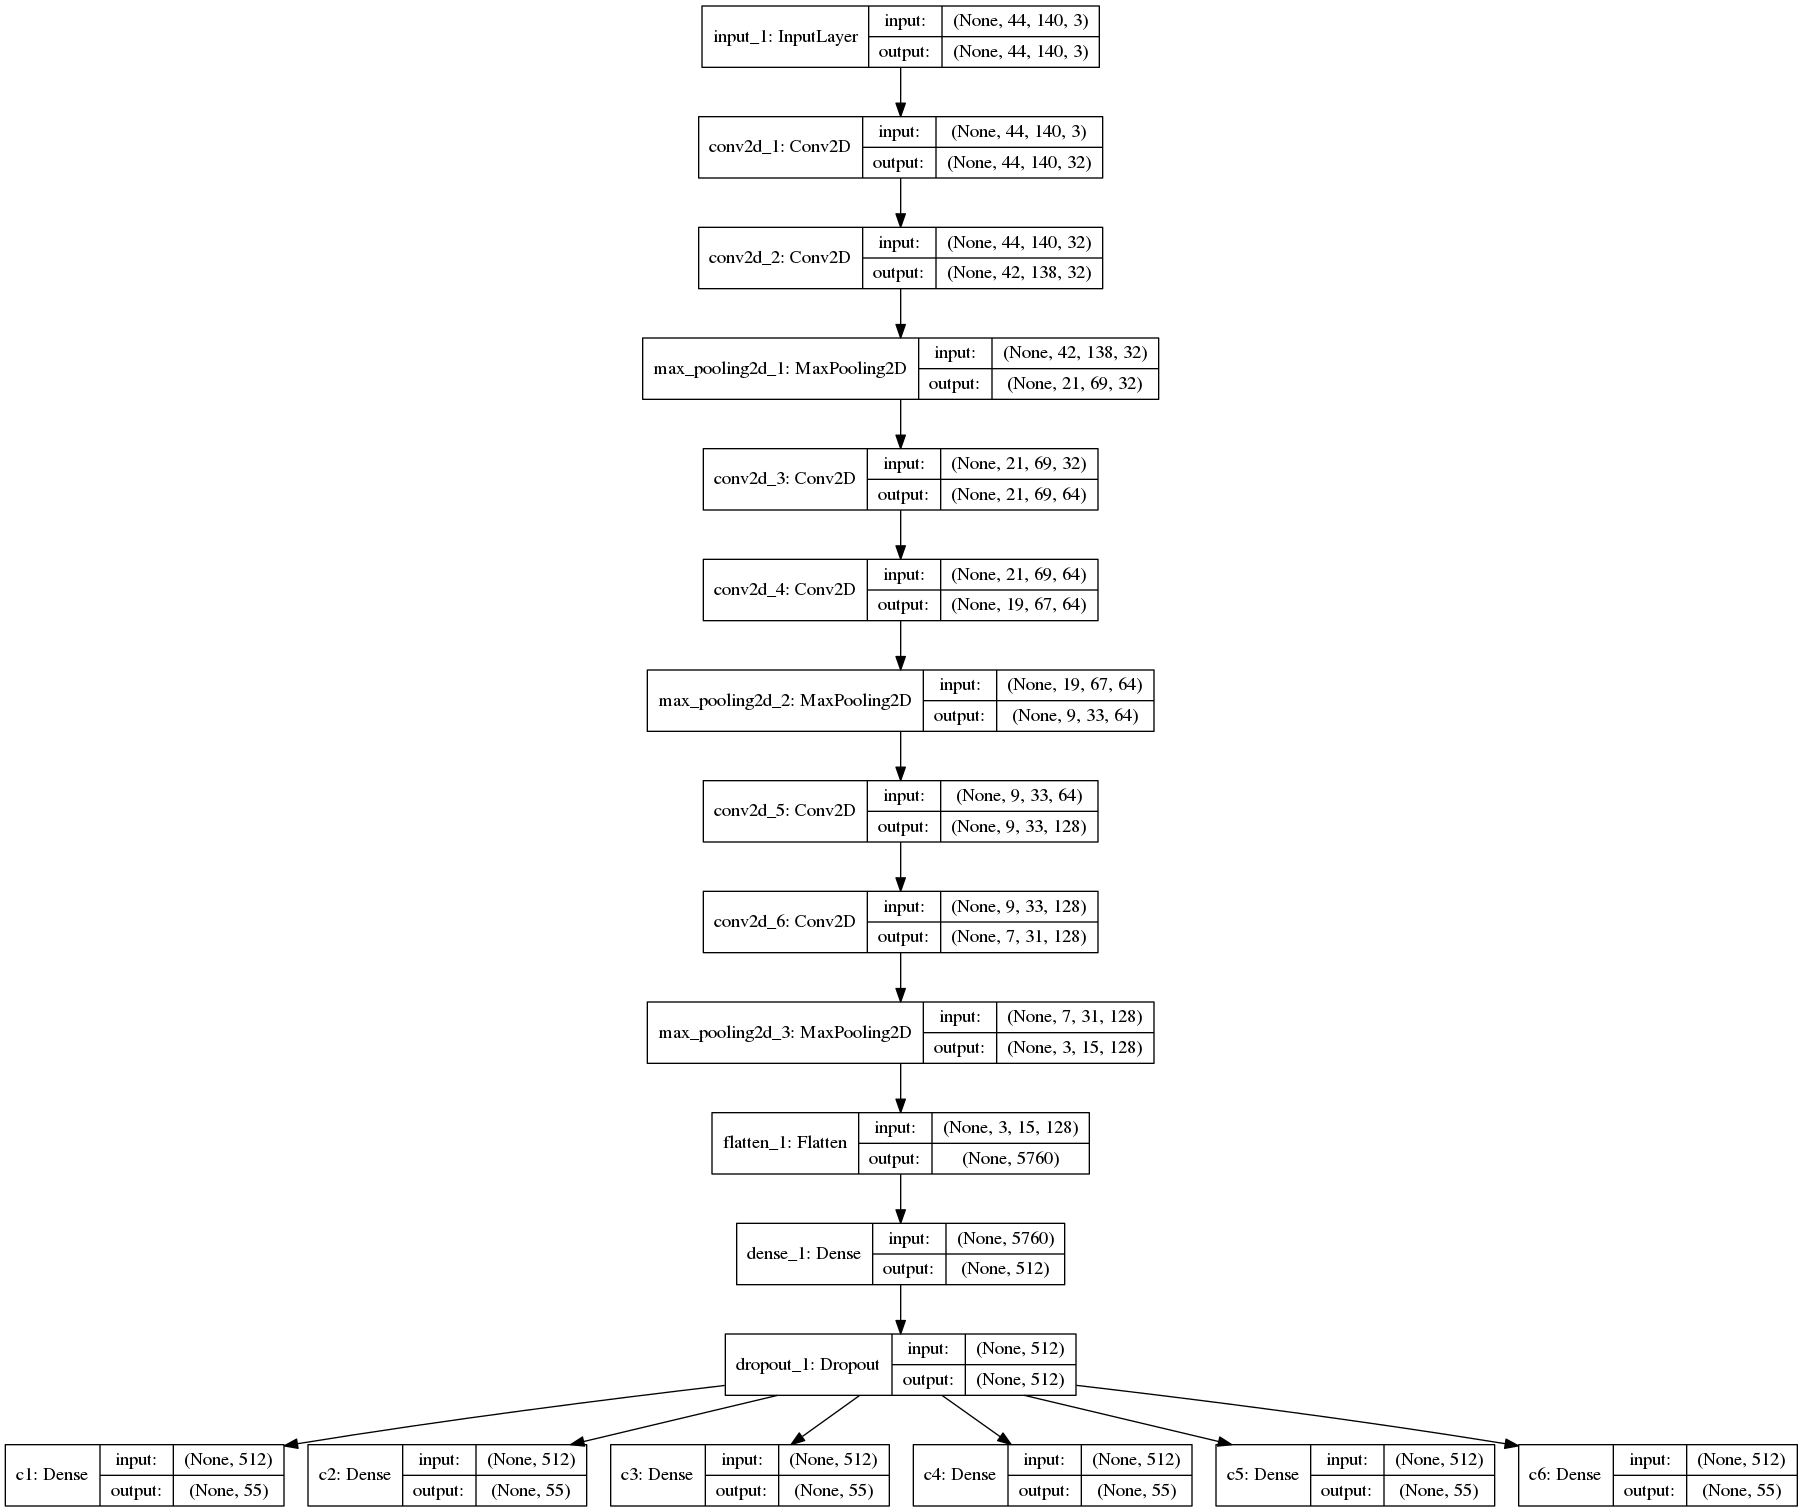

In [12]:
Image('model.png')

In [7]:
sqlContext = SQLContext(sc)

In [7]:
sc.stop()